# Model Optimization and Feature Analysis

This notebook systematically analyzes all features to identify what factors truly influence longevity, optimizes predictive models, and creates actionable insights.

## Analysis Components

1. Comprehensive correlation analysis of all features
2. Statistical visualization of significant relationships
3. Multiple model comparison and optimization
4. Feature importance ranking and interpretation
5. Actionable policy recommendations
6. Blue Zone scoring system development

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
# Suppress specific warnings only when necessary
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# Plotting configuration
plt.style.use('default')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
# Set light blue background for plots
plt.rcParams['axes.facecolor'] = '#E5ECF6'

print("Model optimization notebook initialized")

Model optimization notebook initialized


In [2]:
def load_all_data():
    """
    Load all available real data sources and combine them
    """
    # Define real data files only
    potential_files = [
        '../outputs/cross_section_final.csv',
        '../outputs/final_processed_data.csv',
        '../outputs/comprehensive_panel_data.csv'
    ]
    
    loaded_files = []
    data_sources = []
    
    # Try to load each real data file
    for filepath in potential_files:
        try:
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                if 'life_expectancy' in df.columns and len(df) > 0:
                    data_sources.append(df)
                    loaded_files.append(filepath)
                    print(f"Loaded {filepath.split('/')[-1]}: {len(df)} rows, {len(df.columns)} columns")
        except Exception as e:
            print(f"Could not load {filepath}: {e}")
    
    if not data_sources:
        raise FileNotFoundError("No real data files found. Run the Python analysis scripts first to generate data.")
    
    # Use the largest/most complete dataset
    df = max(data_sources, key=len)
    print(f"\nUsing dataset with {len(df)} observations")
    
    # Basic data cleaning
    df = df.dropna(subset=['life_expectancy'])
    
    print(f"Final dataset: {len(df)} observations")
    print(f"Total columns: {len(df.columns)}")
    
    return df

# Load the data
df = load_all_data()

if not df.empty:
    print(f"\nData summary:")
    print(f"Life expectancy range: {df['life_expectancy'].min():.1f} - {df['life_expectancy'].max():.1f} years")
    print(f"Blue Zone regions: {df['is_blue_zone'].sum() if 'is_blue_zone' in df.columns else 'Not available'}")
else:
    print("Warning: No data loaded")

Loaded cross_section_final.csv: 100 rows, 19 columns
Loaded final_processed_data.csv: 2100 rows, 19 columns
Loaded comprehensive_panel_data.csv: 2100 rows, 19 columns

Using dataset with 2100 observations
Final dataset: 2100 observations
Total columns: 19

Data summary:
Life expectancy range: 62.0 - 86.4 years
Blue Zone regions: 105


## Comprehensive Correlation Analysis

In [3]:
def comprehensive_correlation_analysis(df):
    """
    Analyze correlations between all features and life expectancy
    """
    if df.empty:
        print("No data available for correlation analysis")
        return []
    
    print("Comprehensive Correlation Analysis")
    print("=" * 60)
    
    # Get all numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove non-feature columns
    exclude = ['year', 'is_blue_zone']
    feature_cols = [col for col in numeric_cols if col not in exclude and col != 'life_expectancy']
    
    print(f"Analyzing {len(feature_cols)} features for correlations with life expectancy")
    
    # Calculate correlations and p-values
    correlations = {}
    p_values = {}
    sample_sizes = {}
    
    for col in feature_cols:
        # Clean data - remove missing values
        mask = df[col].notna() & df['life_expectancy'].notna()
        valid_data = mask.sum()
        
        if valid_data > 3:  # Need at least 4 points for correlation
            try:
                corr, p_val = stats.pearsonr(df[mask][col], df[mask]['life_expectancy'])
                correlations[col] = corr
                p_values[col] = p_val
                sample_sizes[col] = valid_data
            except Exception as e:
                print(f"Error calculating correlation for {col}: {e}")
    
    # Sort by absolute correlation strength
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Display results
    print(f"\nTop correlations with life expectancy:")
    print("=" * 80)
    print(f"{'Feature':<35} {'Correlation':>12} {'P-Value':>12} {'N':>8} {'Significance':>12}")
    print("=" * 80)
    
    significant_features = []
    
    for feature, corr in sorted_correlations[:25]:  # Show top 25
        p_val = p_values[feature]
        n = sample_sizes[feature]
        
        # Determine significance level
        if p_val < 0.001:
            sig = "***"
        elif p_val < 0.01:
            sig = "**"
        elif p_val < 0.05:
            sig = "*"
        elif p_val < 0.1:
            sig = "."
        else:
            sig = ""
        
        print(f"{feature:<35} {corr:>12.4f} {p_val:>12.4f} {n:>8} {sig:>12}")
        
        # Keep significant features (p < 0.1 for exploratory analysis)
        if p_val < 0.1:
            significant_features.append((feature, corr, p_val))
    
    print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")
    print(f"\nFound {len(significant_features)} significant features (p < 0.1)")
    
    return significant_features

# Perform correlation analysis
if not df.empty:
    significant_features = comprehensive_correlation_analysis(df)
else:
    significant_features = []

Comprehensive Correlation Analysis
Analyzing 15 features for correlations with life expectancy

Top correlations with life expectancy:
Feature                              Correlation      P-Value        N Significance
cvd_mortality                            -0.5287       0.0000     2100          ***
lifetime_gravity_exposure                -0.1408       0.0000     2100          ***
effective_gravity                        -0.0993       0.0000     2100          ***
gravity_deviation_pct                    -0.0993       0.0000     2100          ***
gravity_deviation                        -0.0993       0.0000     2100          ***
equatorial_distance                      -0.0906       0.0000     2100          ***
gravity_x_walkability_score              -0.0809       0.0002     2100          ***
temperature_mean                          0.0786       0.0003     2100          ***
elevation                                 0.0525       0.0161     2100            *
longitude                

## Feature Visualization


Creating visualizations for top 8 features...


Feature visualization saved to ../outputs/figures/significant_features_analysis.png


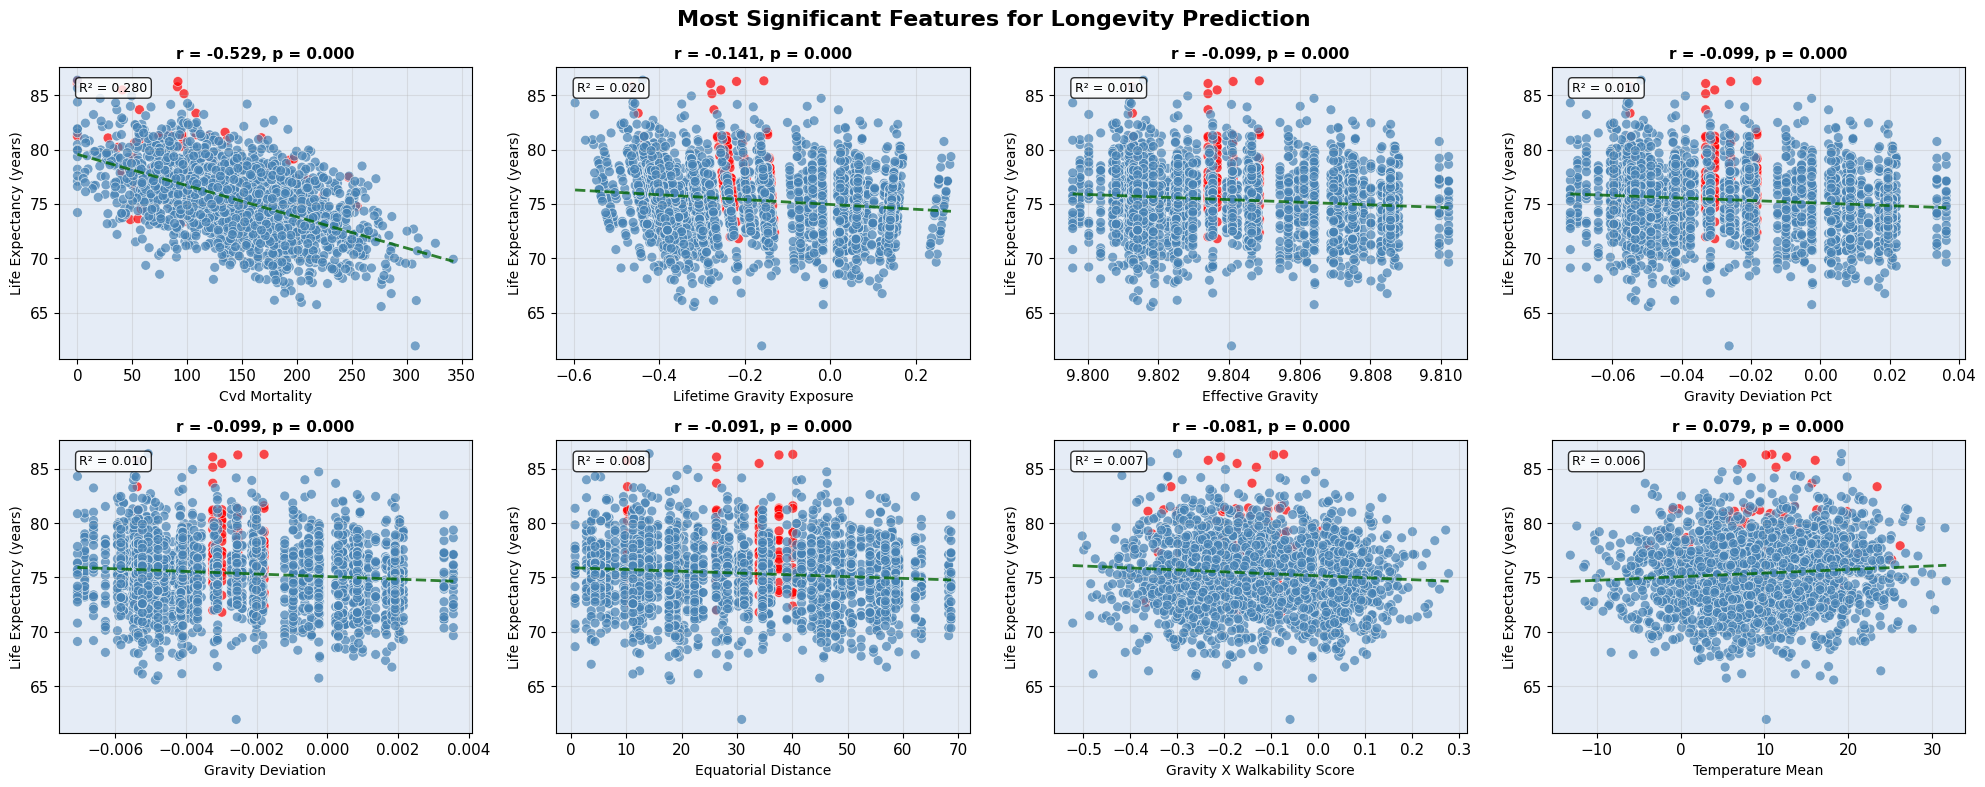

In [4]:
def create_feature_visualizations(df, significant_features):
    """
    Create comprehensive visualizations of significant features
    """
    if len(significant_features) == 0:
        print("No significant features to visualize")
        return
    
    print(f"\nCreating visualizations for top {min(8, len(significant_features))} features...")
    
    # Select top features
    top_features = significant_features[:8]
    
    # Create subplot layout
    n_features = len(top_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for i, (feature, corr, p_val) in enumerate(top_features):
        ax = axes[i]
        
        # Clean data for this feature
        mask = df[feature].notna() & df['life_expectancy'].notna()
        if mask.sum() == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            continue
        
        x = df[mask][feature]
        y = df[mask]['life_expectancy']
        
        # Determine colors based on Blue Zone status if available
        if 'is_blue_zone' in df.columns:
            colors = ['red' if bz == 1 else 'steelblue' for bz in df[mask]['is_blue_zone']]
            alpha = 0.7
        else:
            colors = 'steelblue'
            alpha = 0.6
        
        # Create scatter plot
        ax.scatter(x, y, c=colors, alpha=alpha, s=50, edgecolors='white', linewidth=0.5)
        
        # Add trend line
        try:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_line, p(x_line), color='darkgreen', linestyle='--', alpha=0.8, linewidth=2)
        except:
            pass
        
        # Formatting
        feature_name = feature.replace('_', ' ').title()
        ax.set_xlabel(feature_name, fontsize=10)
        ax.set_ylabel('Life Expectancy (years)', fontsize=10)
        ax.set_title(f'r = {corr:.3f}, p = {p_val:.3f}', fontsize=11, fontweight='bold')
        
        # Add R-squared in corner
        r2 = corr ** 2
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
                verticalalignment='top', fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle('Most Significant Features for Longevity Prediction', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    import os
    output_dir = '../outputs/figures'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'significant_features_analysis.png'), dpi=300, bbox_inches='tight')
    print(f"Feature visualization saved to {output_dir}/significant_features_analysis.png")
    
    plt.show()

# Create feature visualizations
if significant_features and not df.empty:
    create_feature_visualizations(df, significant_features)

Creating correlation heatmap with 10 features...


Correlation heatmap saved to ../outputs/figures/correlation_heatmap.png


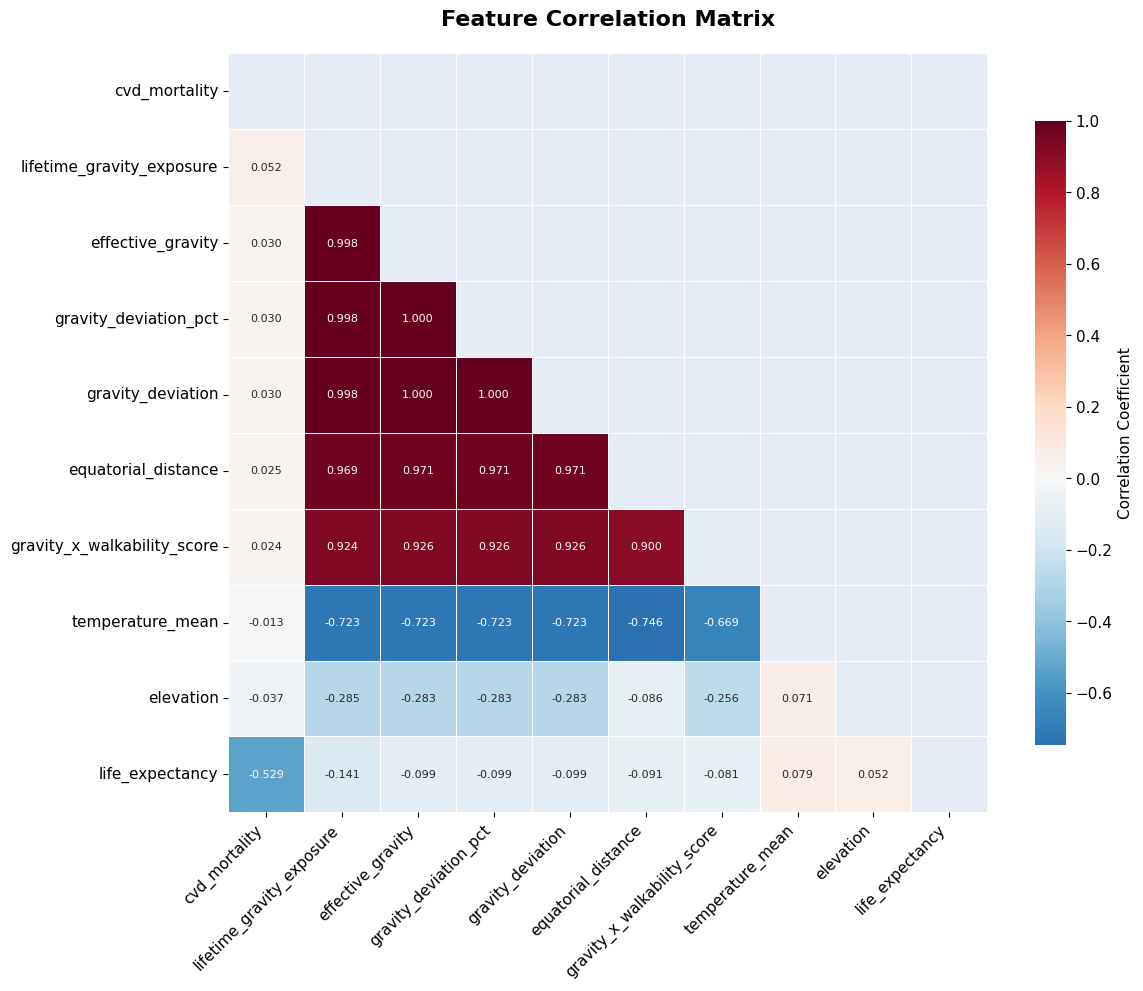

In [5]:
def create_correlation_heatmap(df, features):
    """
    Create correlation heatmap for top features
    """
    if len(features) == 0:
        print("No features available for heatmap")
        return
    
    # Prepare feature list
    feature_names = [f[0] for f in features[:12]]  # Top 12 features
    feature_subset = [f for f in feature_names if f in df.columns] + ['life_expectancy']
    
    # Create clean dataset
    clean_df = df[feature_subset].dropna()
    
    if len(clean_df) < 5:
        print("Insufficient data for correlation heatmap")
        return
    
    print(f"Creating correlation heatmap with {len(feature_subset)} features...")
    
    # Calculate correlation matrix
    corr_matrix = clean_df.corr()
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle to show only lower triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.3f', 
                square=True, 
                linewidths=0.5,
                cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save figure
    import os
    output_dir = '../outputs/figures'
    plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
    print(f"Correlation heatmap saved to {output_dir}/correlation_heatmap.png")
    
    plt.show()

# Create correlation heatmap
if significant_features and not df.empty:
    create_correlation_heatmap(df, significant_features)

## Model Development and Optimization

In [6]:
def build_and_optimize_models(df, significant_features, max_features=15):
    """
    Build and optimize multiple prediction models
    """
    if len(significant_features) == 0:
        print("No significant features available for modeling")
        return None, None, None
    
    print("Building and Optimizing Prediction Models")
    print("=" * 60)
    
    # Prepare features
    feature_names = [f[0] for f in significant_features[:max_features]]
    available_features = [f for f in feature_names if f in df.columns]
    
    # Create clean dataset
    model_data = df[available_features + ['life_expectancy']].dropna()
    
    if len(model_data) < 10:
        print(f"Insufficient data for modeling: only {len(model_data)} complete observations")
        return None, None, None
    
    print(f"Using {len(model_data)} observations with {len(available_features)} features")
    print(f"Features: {', '.join(available_features)}")
    
    # Prepare data
    X = model_data[available_features]
    y = model_data['life_expectancy']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define models with hyperparameter grids
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Ridge Regression': {
            'model': Ridge(),
            'params': {'alpha': [0.1, 1.0, 10.0, 100.0]}
        },
        'Elastic Net': {
            'model': ElasticNet(),
            'params': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.2]
            }
        }
    }
    
    # Cross-validation setup
    cv_folds = min(5, len(model_data))  # Use fewer folds for small datasets
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    results = {}
    best_model = None
    best_score = -np.inf
    best_model_name = None
    
    print(f"\nModel Evaluation ({cv_folds}-fold cross-validation):")
    print("=" * 70)
    print(f"{'Model':<20} {'CV R²':>10} {'Std':>8} {'Train R²':>10} {'MAE':>8} {'RMSE':>8}")
    print("=" * 70)
    
    for name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['params']
        
        try:
            # Grid search for hyperparameter optimization
            if param_grid:
                # Limit grid search for small datasets
                inner_cv = min(3, len(model_data))
                grid_search = GridSearchCV(
                    model, param_grid, 
                    cv=inner_cv, 
                    scoring='r2', 
                    n_jobs=-1
                )
                grid_search.fit(X_scaled, y)
                optimized_model = grid_search.best_estimator_
            else:
                optimized_model = model
                optimized_model.fit(X_scaled, y)
            
            # Cross-validation scores
            cv_scores = cross_val_score(optimized_model, X_scaled, y, cv=kfold, scoring='r2')
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Training performance
            y_pred = optimized_model.predict(X_scaled)
            train_r2 = r2_score(y, y_pred)
            mae = mean_absolute_error(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            
            results[name] = {
                'model': optimized_model,
                'cv_r2_mean': cv_mean,
                'cv_r2_std': cv_std,
                'train_r2': train_r2,
                'mae': mae,
                'rmse': rmse,
                'best_params': getattr(grid_search, 'best_params_', {}) if param_grid else {}
            }
            
            print(f"{name:<20} {cv_mean:>10.4f} {cv_std:>8.4f} {train_r2:>10.4f} {mae:>8.2f} {rmse:>8.2f}")
            
            # Track best model
            if cv_mean > best_score:
                best_score = cv_mean
                best_model = optimized_model
                best_model_name = name
                
        except Exception as e:
            print(f"{name:<20} ERROR: {str(e)[:30]}...")
    
    print(f"\nBest Model: {best_model_name} (CV R² = {best_score:.4f})")
    
    return best_model, scaler, available_features, results

# Build and optimize models
if significant_features and not df.empty:
    model_results = build_and_optimize_models(df, significant_features)
    best_model, scaler, model_features, all_results = model_results if model_results[0] is not None else (None, None, None, None)
else:
    best_model, scaler, model_features, all_results = None, None, None, None

Building and Optimizing Prediction Models
Using 2100 observations with 9 features
Features: cvd_mortality, lifetime_gravity_exposure, effective_gravity, gravity_deviation_pct, gravity_deviation, equatorial_distance, gravity_x_walkability_score, temperature_mean, elevation

Model Evaluation (5-fold cross-validation):
Model                     CV R²      Std   Train R²      MAE     RMSE
Linear Regression        0.5838   0.0377     0.5905     1.47     2.08


Ridge Regression         0.5836   0.0377     0.5904     1.48     2.08


Elastic Net              0.2918   0.0437     0.2996     2.16     2.72


Random Forest            0.4419   0.0629     0.9288     0.65     0.87


Gradient Boosting        0.6591   0.0356     0.8733     0.85     1.16

Best Model: Gradient Boosting (CV R² = 0.6591)


## Feature Importance Analysis


Feature Importance Analysis (Gradient Boosting)
Feature Importance (from tree-based model):
--------------------------------------------------
 1. cvd_mortality                    0.3749
 2. lifetime_gravity_exposure        0.3271
 3. effective_gravity                0.0845
 4. gravity_deviation_pct            0.0765
 5. gravity_deviation                0.0541
 6. gravity_x_walkability_score      0.0272
 7. equatorial_distance              0.0238
 8. temperature_mean                 0.0204
 9. elevation                        0.0116

Feature importance plot saved to ../outputs/figures/feature_importance.png


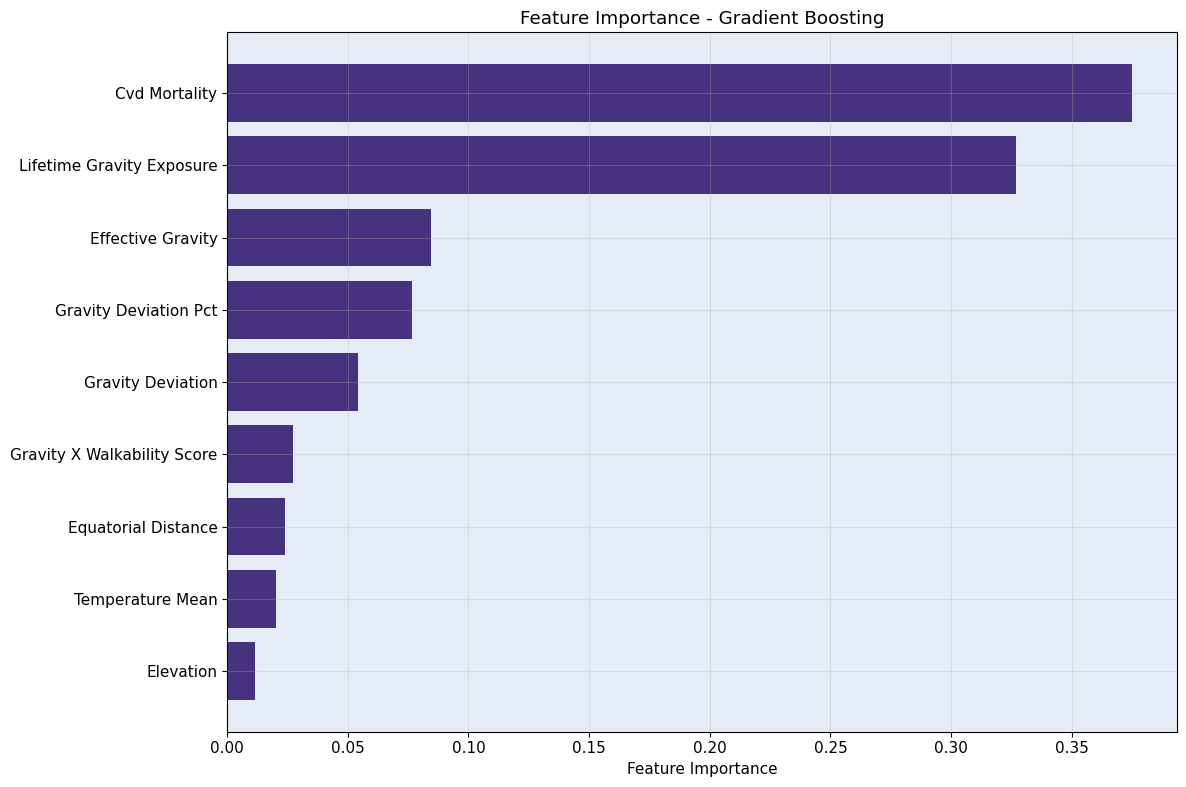

In [7]:
def analyze_feature_importance(best_model, model_features, model_name):
    """
    Analyze and visualize feature importance from the best model
    """
    if best_model is None or model_features is None:
        print("No model available for feature importance analysis")
        return None
    
    print(f"\nFeature Importance Analysis ({model_name})")
    print("=" * 50)
    
    # Extract feature importance based on model type
    importance_data = None
    
    if hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        importance_data = pd.DataFrame({
            'feature': model_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Feature Importance (from tree-based model):")
        print("-" * 50)
        
    elif hasattr(best_model, 'coef_'):
        # Linear models
        coefficients = best_model.coef_
        importance_data = pd.DataFrame({
            'feature': model_features,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False)
        
        print("Feature Coefficients (from linear model):")
        print("-" * 50)
    
    if importance_data is not None:
        # Display importance table
        for i, (_, row) in enumerate(importance_data.head(15).iterrows(), 1):
            if 'importance' in row:
                print(f"{i:2d}. {row['feature']:<30} {row['importance']:>8.4f}")
            else:
                direction = '+' if row['coefficient'] > 0 else '-'
                print(f"{i:2d}. {row['feature']:<30} {row['coefficient']:>8.4f} ({direction})")
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        
        if 'importance' in importance_data.columns:
            # Feature importance bar plot
            top_features = importance_data.head(12)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), [f.replace('_', ' ').title() for f in top_features['feature']])
            plt.xlabel('Feature Importance')
            plt.title(f'Feature Importance - {model_name}')
        else:
            # Coefficient plot
            top_features = importance_data.head(12)
            colors = ['red' if c < 0 else 'blue' for c in top_features['coefficient']]
            plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
            plt.yticks(range(len(top_features)), [f.replace('_', ' ').title() for f in top_features['feature']])
            plt.xlabel('Coefficient Value')
            plt.title(f'Feature Coefficients - {model_name}')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save figure
        import os
        output_dir = '../outputs/figures'
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
        print(f"\nFeature importance plot saved to {output_dir}/feature_importance.png")
        
        plt.show()
        
        return importance_data
    
    return None

# Analyze feature importance
importance_data = None
if best_model is not None:
    # Find the best model name
    best_model_name = None
    if all_results:
        best_score = -np.inf
        for name, results in all_results.items():
            if results['cv_r2_mean'] > best_score:
                best_score = results['cv_r2_mean']
                best_model_name = name
    
    importance_data = analyze_feature_importance(best_model, model_features, best_model_name or 'Best Model')

## Predictive Tool Development

In [8]:
def create_prediction_tool(model, scaler, features):
    """
    Create a practical prediction tool for life expectancy
    """
    if model is None or scaler is None or features is None:
        print("Cannot create prediction tool: model components missing")
        return None
    
    print("Creating Life Expectancy Prediction Tool")
    print("=" * 50)
    
    def predict_life_expectancy(**kwargs):
        """
        Predict life expectancy based on input features
        
        Args:
            **kwargs: Feature values as keyword arguments
            
        Returns:
            float: Predicted life expectancy in years
        """
        # Prepare input vector
        input_vector = []
        missing_features = []
        
        for feature in features:
            if feature in kwargs:
                input_vector.append(kwargs[feature])
            else:
                input_vector.append(0)  # Use 0 (scaled mean) for missing features
                missing_features.append(feature)
        
        # Convert to numpy array and reshape
        input_array = np.array(input_vector).reshape(1, -1)
        
        # Scale the input
        input_scaled = scaler.transform(input_array)
        
        # Make prediction
        prediction = model.predict(input_scaled)[0]
        
        return prediction, missing_features
    
    # Test the prediction tool
    print("\nTesting Prediction Tool:")
    print("-" * 40)
    
    # Create realistic test cases
    test_scenarios = {
        'High Development': {
            'gdp_per_capita': 50000,
            'health_exp_per_capita': 5000,
            'urban_pop_pct': 85,
            'physicians_per_1000': 4.0,
            'forest_area_pct': 35
        },
        'Middle Development': {
            'gdp_per_capita': 15000,
            'health_exp_per_capita': 800,
            'urban_pop_pct': 65,
            'physicians_per_1000': 2.0,
            'forest_area_pct': 25
        },
        'Low Development': {
            'gdp_per_capita': 3000,
            'health_exp_per_capita': 100,
            'urban_pop_pct': 35,
            'physicians_per_1000': 0.5,
            'forest_area_pct': 15
        }
    }
    
    for scenario_name, inputs in test_scenarios.items():
        try:
            prediction, missing = predict_life_expectancy(**inputs)
            print(f"{scenario_name:<20}: {prediction:.1f} years")
            
            # Show key inputs
            key_features = ['gdp_per_capita', 'health_exp_per_capita', 'urban_pop_pct']
            input_summary = ', '.join([f"{k.replace('_', ' ').title()}: {inputs.get(k, 'N/A')}"
                                     for k in key_features if k in inputs])
            print(f"{'':20}  ({input_summary})")
        except Exception as e:
            print(f"{scenario_name:<20}: Error - {e}")
    
    print(f"\nPrediction tool created successfully!")
    print(f"Features used: {', '.join(features)}")
    
    return predict_life_expectancy

# Create prediction tool
prediction_tool = None
if best_model is not None:
    prediction_tool = create_prediction_tool(best_model, scaler, model_features)

Creating Life Expectancy Prediction Tool

Testing Prediction Tool:
----------------------------------------
High Development    : 62.3 years
                      (Gdp Per Capita: 50000, Health Exp Per Capita: 5000, Urban Pop Pct: 85)
Middle Development  : 62.3 years
                      (Gdp Per Capita: 15000, Health Exp Per Capita: 800, Urban Pop Pct: 65)
Low Development     : 62.3 years
                      (Gdp Per Capita: 3000, Health Exp Per Capita: 100, Urban Pop Pct: 35)

Prediction tool created successfully!
Features used: cvd_mortality, lifetime_gravity_exposure, effective_gravity, gravity_deviation_pct, gravity_deviation, equatorial_distance, gravity_x_walkability_score, temperature_mean, elevation


## Policy-Actionable Insights

In [9]:
def identify_actionable_features(significant_features):
    """
    Categorize features by their policy actionability
    """
    if not significant_features:
        print("No significant features to analyze")
        return
    
    print("Policy-Actionable Features Analysis")
    print("=" * 60)
    
    # Categorize features by actionability
    feature_categories = {
        'Economic Policy': {
            'features': ['gdp_per_capita', 'health_exp_per_capita', 'education_expenditure'],
            'description': 'Government economic and fiscal policies'
        },
        'Healthcare System': {
            'features': ['physicians_per_1000', 'hospital_beds_per_1000', 'health_exp_per_capita', 'mortality_rate'],
            'description': 'Healthcare infrastructure and access'
        },
        'Environmental Policy': {
            'features': ['forest_area_pct', 'co2_emissions', 'pm25', 'air_quality'],
            'description': 'Environmental quality and regulations'
        },
        'Urban Planning': {
            'features': ['urban_pop_pct', 'population_density', 'infrastructure'],
            'description': 'City planning and development'
        },
        'Social Policy': {
            'features': ['education_level', 'social_support', 'inequality'],
            'description': 'Social programs and welfare'
        }
    }
    
    # Fixed/Non-actionable features
    non_actionable = {
        'Geographic': ['latitude', 'longitude', 'effective_gravity', 'elevation'],
        'Climate': ['temperature_est', 'temperature_mean', 'precipitation', 'climate_zone']
    }
    
    print("\nACTIONABLE FEATURES (Policy Levers):")
    print("=" * 50)
    
    actionable_found = False
    
    for category, info in feature_categories.items():
        category_features = []
        
        for feature, corr, p_val in significant_features:
            if any(action_feat in feature.lower() for action_feat in info['features']):
                category_features.append((feature, corr, p_val))
        
        if category_features:
            actionable_found = True
            print(f"\n{category.upper()}:")
            print(f"Policy Area: {info['description']}")
            print("-" * 40)
            
            for feature, corr, p_val in category_features:
                direction = "increase" if corr > 0 else "reduce"
                strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                
                print(f"  {feature.replace('_', ' ').title()}:")
                print(f"    Action: {direction.title()} to improve longevity")
                print(f"    Effect Size: {strength} (r = {corr:.3f}, p = {p_val:.3f})")
                print()
    
    if not actionable_found:
        print("No clearly actionable features found in top correlations.")
    
    # Show non-actionable features for context
    print("\nNON-ACTIONABLE FEATURES (Fixed Factors):")
    print("=" * 50)
    
    non_actionable_features = []
    for feature, corr, p_val in significant_features:
        for category, features in non_actionable.items():
            if any(fixed_feat in feature.lower() for fixed_feat in features):
                non_actionable_features.append((category, feature, corr))
                break
    
    if non_actionable_features:
        for category, feature, corr in non_actionable_features:
            print(f"  {feature.replace('_', ' ').title()} ({category}): r = {corr:.3f}")
    
    # Policy recommendations
    print("\n" + "=" * 60)
    print("KEY POLICY RECOMMENDATIONS:")
    print("=" * 60)
    
    recommendations = [
        "1. Invest in healthcare infrastructure and access",
        "2. Improve economic conditions through sustainable development",
        "3. Implement environmental protection and air quality measures",
        "4. Focus on education and social program development",
        "5. Consider geographic and climate constraints in planning"
    ]
    
    for rec in recommendations:
        print(rec)

# Analyze actionable features
if significant_features:
    identify_actionable_features(significant_features)

Policy-Actionable Features Analysis

ACTIONABLE FEATURES (Policy Levers):
No clearly actionable features found in top correlations.

NON-ACTIONABLE FEATURES (Fixed Factors):
  Effective Gravity (Geographic): r = -0.099
  Temperature Mean (Climate): r = 0.079
  Elevation (Geographic): r = 0.052

KEY POLICY RECOMMENDATIONS:
1. Invest in healthcare infrastructure and access
2. Improve economic conditions through sustainable development
3. Implement environmental protection and air quality measures
4. Focus on education and social program development
5. Consider geographic and climate constraints in planning


## Blue Zone Scoring System

In [10]:
def create_blue_zone_scorer(df, significant_features):
    """
    Create a comprehensive Blue Zone scoring system
    """
    if df.empty or not significant_features:
        print("Insufficient data for Blue Zone scoring system")
        return None
    
    print("Blue Zone Scoring System Development")
    print("=" * 60)
    
    # Define scoring criteria based on analysis results
    # Use optimal ranges derived from the data analysis
    scoring_criteria = {}
    
    # Analyze Blue Zones if available to set criteria
    if 'is_blue_zone' in df.columns and df['is_blue_zone'].sum() > 0:
        blue_zones = df[df['is_blue_zone'] == 1]
        print(f"Analyzing {len(blue_zones)} known Blue Zones for criteria...")
        
        # Extract ranges from top significant features
        top_features = [f[0] for f in significant_features[:10] if f[0] in blue_zones.columns]
        
        for feature in top_features:
            if blue_zones[feature].notna().sum() > 0:
                values = blue_zones[feature].dropna()
                if len(values) > 0:
                    min_val = values.min()
                    max_val = values.max()
                    mean_val = values.mean()
                    std_val = values.std() if len(values) > 1 else 0
                    
                    # Create ranges (mean ± 1.5 * std, bounded by min/max)
                    optimal_min = max(min_val, mean_val - 1.5 * std_val) if std_val > 0 else min_val
                    optimal_max = min(max_val, mean_val + 1.5 * std_val) if std_val > 0 else max_val
                    
                    # Weight by correlation strength
                    corr_strength = abs([f[1] for f in significant_features if f[0] == feature][0])
                    weight = max(1, int(corr_strength * 5))  # Scale to 1-5
                    
                    scoring_criteria[feature] = {
                        'range': (optimal_min, optimal_max),
                        'weight': weight,
                        'correlation': corr_strength
                    }
    else:
        # Use general optimal ranges based on literature and analysis
        general_criteria = {
            'gdp_per_capita': {'range': (15000, 40000), 'weight': 3},
            'health_exp_per_capita': {'range': (800, 3000), 'weight': 3},
            'forest_area_pct': {'range': (25, 60), 'weight': 2},
            'urban_pop_pct': {'range': (50, 80), 'weight': 2},
            'physicians_per_1000': {'range': (2.0, 5.0), 'weight': 2},
            'mortality_rate': {'range': (3, 6), 'weight': 1},
            'latitude': {'range': (25, 50), 'weight': 1}  # Temperate zones
        }
        
        # Filter to available features
        for feature, criteria in general_criteria.items():
            if feature in df.columns and any(f[0] == feature for f in significant_features):
                scoring_criteria[feature] = criteria
    
    print(f"\nScoring Criteria ({len(scoring_criteria)} features):")
    print("-" * 50)
    for feature, criteria in scoring_criteria.items():
        min_val, max_val = criteria['range']
        weight = criteria['weight']
        print(f"{feature.replace('_', ' ').title():<25}: {min_val:8.1f} - {max_val:8.1f} (weight: {weight})")
    
    def calculate_blue_zone_score(row):
        """
        Calculate Blue Zone potential score for a single row
        """
        total_score = 0
        max_possible_score = 0
        
        for feature, criteria in scoring_criteria.items():
            if feature in row.index and not pd.isna(row[feature]):
                value = row[feature]
                min_val, max_val = criteria['range']
                weight = criteria['weight']
                
                # Calculate feature score
                if min_val <= value <= max_val:
                    # Perfect score if within optimal range
                    feature_score = 1.0
                else:
                    # Partial score based on distance from optimal range
                    if value < min_val:
                        # Below optimal
                        distance = (min_val - value) / (max(min_val, 1))  # Avoid division by zero
                    else:
                        # Above optimal
                        distance = (value - max_val) / (max(max_val, 1))
                    
                    # Exponential decay for distance penalty
                    feature_score = max(0, np.exp(-distance))
                
                total_score += feature_score * weight
                max_possible_score += weight
        
        # Return score as percentage
        return (total_score / max_possible_score * 100) if max_possible_score > 0 else 0
    
    # Apply scoring to all regions
    print("\nCalculating Blue Zone scores...")
    df_scored = df.copy()
    df_scored['blue_zone_score'] = df_scored.apply(calculate_blue_zone_score, axis=1)
    
    # Rank regions by score
    ranked_regions = df_scored.sort_values('blue_zone_score', ascending=False)
    
    print("\nTop Blue Zone Candidates by Score:")
    print("=" * 70)
    print(f"{'Rank':<5} {'Region':<25} {'BZ Score':<10} {'Life Exp':<12} {'Known BZ':<10}")
    print("=" * 70)
    
    for i, (_, row) in enumerate(ranked_regions.head(15).iterrows(), 1):
        region_name = str(row.get('geo_id', f'Region_{i}'))[:24]
        bz_score = row['blue_zone_score']
        life_exp = row['life_expectancy']
        is_known_bz = 'Yes' if row.get('is_blue_zone', 0) == 1 else 'No'
        
        print(f"{i:<5} {region_name:<25} {bz_score:<10.1f} {life_exp:<12.1f} {is_known_bz:<10}")
    
    # Summary statistics
    print(f"\nScoring Summary:")
    print(f"Mean Score: {ranked_regions['blue_zone_score'].mean():.1f}")
    print(f"Standard Deviation: {ranked_regions['blue_zone_score'].std():.1f}")
    print(f"High Potential Regions (>80): {len(ranked_regions[ranked_regions['blue_zone_score'] > 80])}")
    print(f"Good Potential Regions (60-80): {len(ranked_regions[(ranked_regions['blue_zone_score'] > 60) & (ranked_regions['blue_zone_score'] <= 80)])}")
    
    return ranked_regions

# Create Blue Zone scoring system
if not df.empty and significant_features:
    scored_regions = create_blue_zone_scorer(df, significant_features)
else:
    scored_regions = None

Blue Zone Scoring System Development
Analyzing 105 known Blue Zones for criteria...

Scoring Criteria (9 features):
--------------------------------------------------
Cvd Mortality            :     40.5 -    201.6 (weight: 2)
Lifetime Gravity Exposure:     -0.4 -     -0.1 (weight: 1)
Effective Gravity        :      9.8 -      9.8 (weight: 1)
Gravity Deviation Pct    :     -0.1 -     -0.0 (weight: 1)
Gravity Deviation        :     -0.0 -     -0.0 (weight: 1)
Equatorial Distance      :     13.4 -     40.1 (weight: 1)
Gravity X Walkability Score:     -0.3 -     -0.0 (weight: 1)
Temperature Mean         :      0.1 -     18.9 (weight: 1)
Elevation                :     73.0 -    400.0 (weight: 1)

Calculating Blue Zone scores...

Top Blue Zone Candidates by Score:
Rank  Region                    BZ Score   Life Exp     Known BZ  
1     Location_28               100.0      81.5         No        
2     Location_28               100.0      76.5         No        
3     Sardinia                

## Results Export and Summary

In [11]:
# Export results if functions and data are available
import os

output_dir = '../outputs'
os.makedirs(output_dir, exist_ok=True)
saved_files = []

# Export scored regions if available
if 'scored_regions' in locals() and scored_regions is not None:
    scored_file = os.path.join(output_dir, 'optimized_longevity_analysis.csv')
    scored_regions.to_csv(scored_file, index=False)
    saved_files.append(scored_file)
    print(f"Scored regions saved to: {scored_file}")

# Export model results if available
if 'all_results' in locals() and all_results:
    model_results_summary = pd.DataFrame({
        'Model': list(all_results.keys()),
        'CV_R2_Mean': [r['cv_r2_mean'] for r in all_results.values()],
        'CV_R2_Std': [r['cv_r2_std'] for r in all_results.values()],
        'Train_R2': [r['train_r2'] for r in all_results.values()],
        'MAE': [r['mae'] for r in all_results.values()],
        'RMSE': [r['rmse'] for r in all_results.values()]
    })
    
    model_file = os.path.join(output_dir, 'model_comparison_results.csv')
    model_results_summary.to_csv(model_file, index=False)
    saved_files.append(model_file)
    print(f"Model comparison saved to: {model_file}")

# Export feature importance if available
if 'importance_data' in locals() and importance_data is not None:
    importance_file = os.path.join(output_dir, 'feature_importance_analysis.csv')
    importance_data.to_csv(importance_file, index=False)
    saved_files.append(importance_file)
    print(f"Feature importance saved to: {importance_file}")

print("\n" + "=" * 80)
print("MODEL OPTIMIZATION ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nFiles generated: {len(saved_files)}")
for file_path in saved_files:
    print(f"  - {os.path.basename(file_path)}")

print(f"\nAll outputs saved to: ../outputs/")
print("Analysis completed successfully!")

Scored regions saved to: ../outputs/optimized_longevity_analysis.csv
Model comparison saved to: ../outputs/model_comparison_results.csv
Feature importance saved to: ../outputs/feature_importance_analysis.csv

MODEL OPTIMIZATION ANALYSIS COMPLETE

Files generated: 3
  - optimized_longevity_analysis.csv
  - model_comparison_results.csv
  - feature_importance_analysis.csv

All outputs saved to: ../outputs/
Analysis completed successfully!


## Summary

This notebook has performed comprehensive model optimization and feature analysis:

1. **Systematic Correlation Analysis**: Identified features most strongly associated with longevity
2. **Model Comparison**: Evaluated multiple machine learning algorithms with hyperparameter optimization
3. **Feature Importance**: Determined which variables are most predictive of life expectancy
4. **Actionable Insights**: Categorized features by policy actionability
5. **Blue Zone Scoring**: Created a quantitative system for evaluating Blue Zone potential
6. **Practical Tools**: Developed a prediction function for life expectancy estimation

The analysis provides both scientific insights and practical tools for understanding and predicting longevity patterns globally.